The subject of this tutorial analyizing the trends of pollution levels in the Chesapeake Bay from the year 2000 to 2020.

[external link text](https://community.dataquest.io/t/jupyter-notebook-hyperlink/45370/2)

The goal of this tutorial is to determine if Maryland will reach the [pollution goals](https://www.chesapeakeprogress.com/clean-water/watershed-implementation-plans) set for itself by the year 2025 and what that will mean for the Chesapeake Bay.
Over the course of this project I will show the relationship between pollution levels, HABs, cleanup efforts, and water quality.

Our pollution analysis will focus on nutrient pollution. Nutrient pollution consists of three main components: Nitrogen, Phosphorus, and soil. Human derived nutrient pollution has been an affliction in the Chesapeake Bay for [over fifty years](https://mde.maryland.gov/programs/Water/TMDL/TMDLImplementation/Pages/overview.aspx). During the 1970s pollution hit a critical point as the aquatic life in the bay started to disappear. Due to the decline in aquatic life, efforts were started to determine the causes and solutions to the decline in the quality of the Chesapeake Bay waters. The EPA created a study and at the end of the [five-year study](https://www.chesapeakebay.net/content/publications/cbp_13280.pdf) the EPA determined that nutrient pollution was the cause of the decline in the quality of the bay.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import folium
from folium import plugins
from folium.plugins import HeatMap
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from IPython.display import Image

In [10]:
def sub_list(original, search): #takes a list and returns elements from the list that contain the search parameter
    return [i for i in original if search in i]

def unwanted_list(full,wanted): # Sets: all bodies - desired bodies = unwanted bodies
    return list(set(full)-set(wanted))

def scale_col(column):#normalizes the values of the column passed in
    return (column - column.mean()) / column.std()

def ave_lin_reg_plot(frame, labels, title):#used for west vs east bay plots as they were repetative
    ave_frame =  frame.groupby(['Major Basin','Year']).mean().reset_index()
    basins = ave_frame['Major Basin'].unique()
    for basin in basins:
        data = ave_frame[ave_frame['Major Basin'] == basin]
        X = data.Year[1:-2].astype(int)
        y = data["Total lbs."][1:-2]
        sns.regplot(x=X, y=y)
    plt.legend(labels=labels, loc = 2, bbox_to_anchor = (1,1))
    plt.title(title)
    
def pollution_cleaning(filename):
    df = pd.read_csv(filename)
    df.drop(['Land-River Segment', 'FIPS'], axis=1, inplace=True)

    temp_dict = {}
    for column in df.columns[4:]:
        temp_dict[column] = re.findall("\d{4}", column)[0]

    df.rename(columns=temp_dict, inplace = True)
    df = pd.melt(df,id_vars=['County','Tributary Basin','Major Basin','Source Sector'], \
                          var_name='Year', value_name='Total lbs.')

    unwanted = sub_list(df['Major Basin'].unique() ,"Basin")
    df = df.set_index("Major Basin")
    df.drop(unwanted,axis=0,inplace=True)
    df = df.reset_index()

    wanted = sub_list(df['Tributary Basin'].unique(),"Shore")
    all_bodies = df['Tributary Basin'].unique()
    df = df.set_index("Tributary Basin")
    df.drop( unwanted_list( all_bodies, wanted) , axis=0, inplace=True)
    df = df.reset_index()
    
    return df

We scrapped the data for these pollutants from the [Maryland Open Data Portal](https://opendata.maryland.gov/), a website created by the Maryland government that provides publicly accessible datasets. Due to the nature of the data that we analyze it cannot reveal a complete depiction of pollution. This is because there are two general categories of pollution sources: point and nonpoint pollution. The MD Department of the Environment denotes [point pollution](https://mde.maryland.gov/programs/Water/TMDL/TMDLImplementation/Pages/pollution-in-the-chesapeake.aspx) as “originates from a single, easily identifiable source, and is the form of pollution with which most people are familiar.” [Non-point pollution](https://mde.maryland.gov/programs/Water/TMDL/TMDLImplementation/Pages/pollution-in-the-chesapeake.aspx) is denoted as “comes from a broad area where it is not possible to readily identify a single source of contamination.” 

To clean the initial pollution datasets we had to 
-  Remove irrelevant bodies of water using the pandas [drop feature](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html)
-  We determined that the bodies were irrelevant if they did not connect directly with the Cheasapeake Bay 
-  Reformat the columns of the year for observations to graph the data later 
    -   EX: Total N, 1985 (lb.) → 1985
-  Use the pandas [melt feature](https://pandas.pydata.org/docs/reference/api/pandas.melt.html) to convert the dataset from wide to long
    -  Before
        -  County
        -  Tributary Basin
        -  Major Basin
        -  Source Sector
        -  Total N, 1985 (lb.) … Total N, 2016(lb.)
    -  After
        -  County
        -  Tributary Basin
        -  Major Basin
        -  Source Sector
        -  Year
        -  Total lbs.
        
After I cleaned the data I created visualizations for the trends of the data. For the pollution data I used the python library [Seaborn](https://seaborn.pydata.org/). If you want the basics of Seaborn I highly suggest reading [this article](https://towardsdatascience.com/seaborn-python-8563c3d0ad41#:~:text=Seaborn%20is%20a%20data%20visualization,Pandas%20to%20learn%20about%20Seaborn.). The trends that Seaborn’s [regplot feature](https://seaborn.pydata.org/generated/seaborn.regplot.html) created showed that the nutrients pollution data could easily be estimated with a simple linear regression. The simplicity of the regression can most likely be attributed to people because pollution is created and controlled by people, which means that there are most likely guidelines and goals that are being followed. 

After creating the visualization for the nutrient pollution it was apparent that location was another factor affecting the data. After removing the unnecessary major basins the only basins left in the dataset were the Western and Eastern Chesapeake Bay. The graph creates a fantastic visual representation of the differences between the two locations in the bay. To make the different bays more apparent I made them different colors with the [matplotlib legend](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html) feature. It appears that the linear regression for the Western bay is expected to be ten times greater than the regression for the Eastern bay. 

In [11]:
nitrogen_df = pollution_cleaning('Nitrogen_loads.csv')
phosphorus_df = pollution_cleaning('Phosphorus_loads.csv')
soil_df = pollution_cleaning('Sediment_loads.csv')

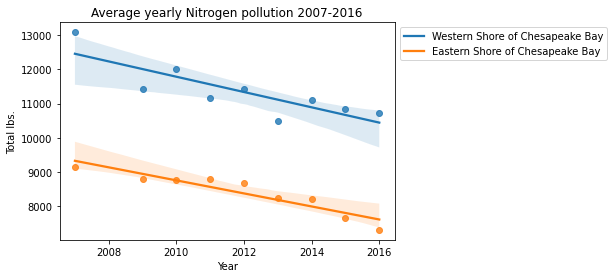

In [12]:
ave_lin_reg_plot(nitrogen_df,nitrogen_df['Major Basin'].unique(),"Average yearly Nitrogen pollution 2007-2016")

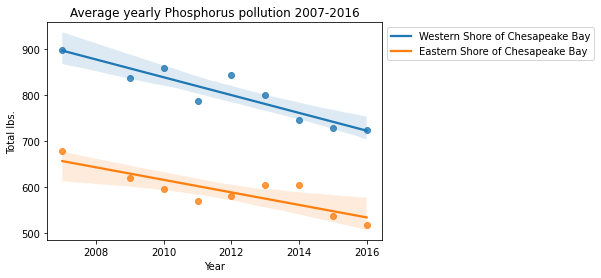

In [13]:
ave_lin_reg_plot(phosphorus_df,phosphorus_df['Major Basin'].unique(),"Average yearly Phosphorus pollution 2007-2016")

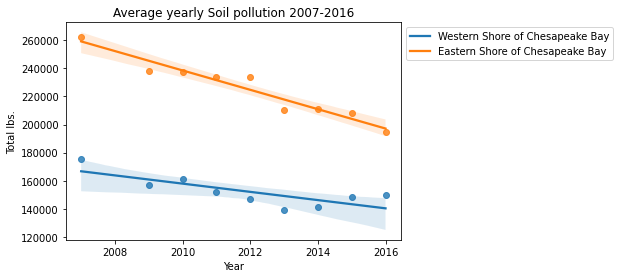

In [14]:
ave_lin_reg_plot(soil_df,soil_df['Major Basin'].unique(),"Average yearly Soil pollution 2007-2016")

Ignore results for 2017 and 2025 because those were predictions that the reseachers made. The only measured values are 2007-2016

Text(0, 0.5, 'Total lbs.')

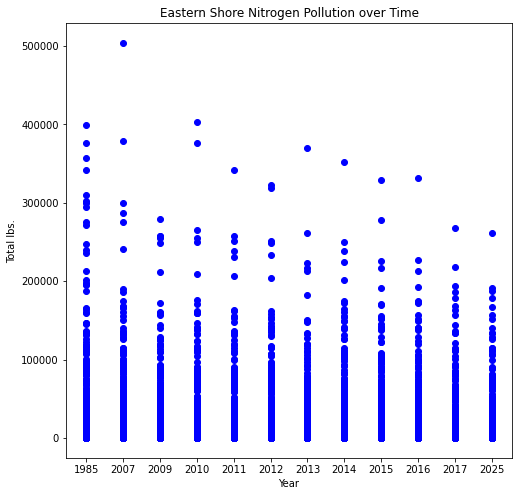

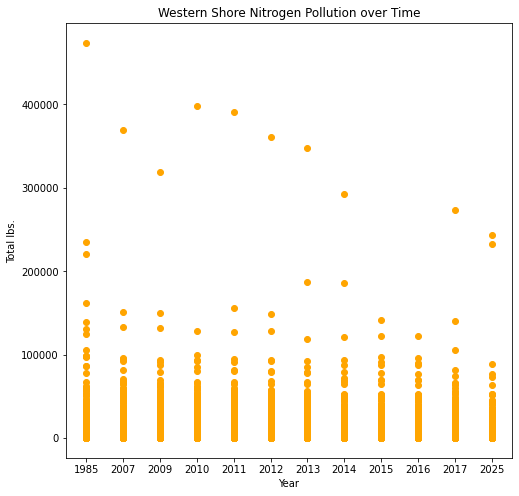

In [15]:
fig = plt.figure(figsize = (8, 8))
eastern_shore = nitrogen_df[nitrogen_df['Major Basin'] == 'Eastern Shore of Chesapeake Bay']
western_shore = nitrogen_df[nitrogen_df['Major Basin'] == 'Western Shore of Chesapeake Bay']
plt.scatter(eastern_shore['Year'], eastern_shore['Total lbs.'], c = "blue")
plt.xlabel('Year')
plt.ylabel('Total lbs.')
plt.title("Eastern Shore Nitrogen Pollution over Time")
fig = plt.figure(figsize = (8, 8))
plt.scatter(western_shore['Year'], western_shore['Total lbs.'], c = "orange")
plt.title("Western Shore Nitrogen Pollution over Time")
plt.xlabel('Year')
plt.ylabel('Total lbs.')

Here it seems that the data for nitrogen pollution is trending downwards, but it is still a bit hard to tell because the points are mainly grouped together towards the bottom of the plot. The strip plot below shows that the concentration lies mainly at the bottom and that it takes up a lot of space.

Text(0.5, 1.0, 'Eastern Shore Total Pounds of Nitrogen per Year')

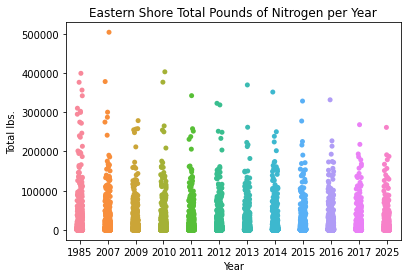

In [16]:
sns.stripplot(data = eastern_shore, x = eastern_shore['Year'], y = eastern_shore['Total lbs.'])
plt.title("Eastern Shore Total Pounds of Nitrogen per Year")

Text(0.5, 1.0, 'Western Shore Total Pounds of Nitrogen per Year')

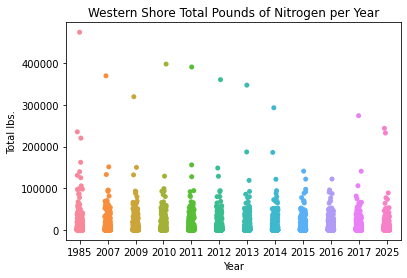

In [17]:
sns.stripplot(data = western_shore, x = western_shore['Year'], y = western_shore['Total lbs.'])
plt.title("Western Shore Total Pounds of Nitrogen per Year")

To make it easier to see the data, we took averages of each year and plotted them. This method is affected by outliers but due to the amount of points at the lower end of Total lbs we thought that the distribution would still be good. The regression lines we have here show that there is in fact a negative correlation between nitrogen pollution and time over the last decade or so. This is because there has been an effort in the bay to cleanup pollution.

Text(0.5, 1.0, 'Western Shore Phosphorus Pollution over time.')

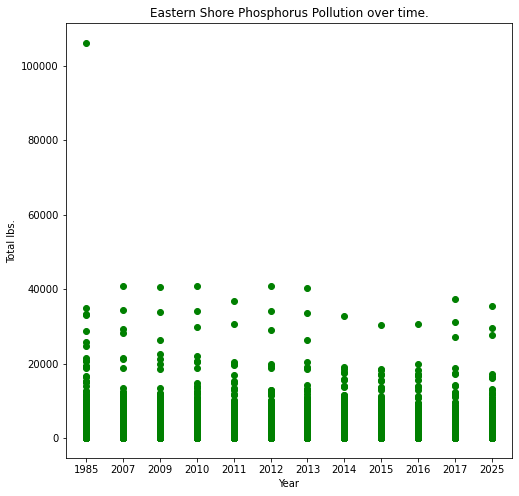

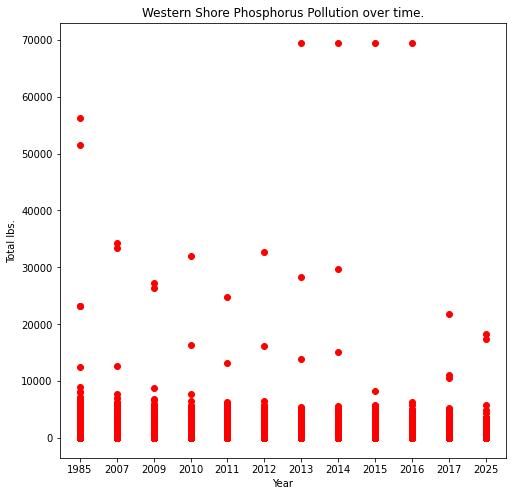

In [18]:
eastern_phosphorus = phosphorus_df[phosphorus_df['Major Basin'] == "Eastern Shore of Chesapeake Bay"]
western_phosphorus = phosphorus_df[phosphorus_df['Major Basin'] == "Western Shore of Chesapeake Bay"]

fig = plt.figure(figsize = (8, 8))
plt.scatter(eastern_phosphorus['Year'], eastern_phosphorus['Total lbs.'], c = "green")
plt.xlabel("Year")
plt.ylabel("Total lbs.")
plt.title("Eastern Shore Phosphorus Pollution over time.")

fig = plt.figure(figsize = (8, 8))
plt.scatter(western_phosphorus['Year'], western_phosphorus['Total lbs.'], c = "red")
plt.xlabel("Year")
plt.ylabel("Total lbs.")
plt.title("Western Shore Phosphorus Pollution over time.")

The reason that the eastern shore has more pollution is due to nitrogen in groundwater. This is evidenced here https://www.chesapeakebay.net/news/blog/excess_nitrogen_phosphorus_flow_from_eastern_shore_to_bay_waters

To clean the Living resources (microorganisms) datasets I had to 
-  Remove unnecessary columns (pandas drop)
    - ReportingUnit
    - Parameter
    - SampleType
    - SampleNumber
    - TSN
    - NODCCode
    - SPECCode
- Removing unnecessary observations (removed rows using pandas drop)
    - I created a set of the microorganisms that I wanted and removed them from a set of all the microorganisms
    - After I removed all the microorganisms that were unwanted
- Reformatting the sample date to just be years
    - Keep only the year from the sample date to simplify linear regression

The microorganism and dissolved oxygen data followed a non linear trend over the time; a polynomial linear regression of the fourth power provided the best fit for the data. A polynomial linear regression provided a better fit for the data due to the numerous variables that impact dissolved oxygen levels and microorganism growth.

In [19]:
algae_df = pd.read_csv('LivingResourcesReportedStation.csv', low_memory =False, parse_dates=True)
desired = ['Prorocentrum minimum','Prorocentrum micans','Blue green sphere','Prorocentrum gracile']
all_alg = algae_df['LatinName'].unique()
# Sets: all bodies - desired bodies = unwanted bodies
unwanted = list(set(all_alg)-set(desired))

algae_df = algae_df.set_index("LatinName")
algae_df.drop(unwanted,axis=0,inplace=True)
algae_df = algae_df.reset_index()

algae_df = algae_df.rename(columns={"ReportingValue": "ReportingValue(L)"})
algae_df = algae_df.drop(['ReportingUnit','Parameter','SampleType','SampleNumber','TSN','NODCCode','SPECCode'], axis=1)

year = []
for date in algae_df.SampleDate:
    year.append(date[-4:])    
algae_df['Year'] = year
algae_df['Year'] = algae_df['Year'].astype(int)

https://www.cbf.org/how-we-save-the-bay/chesapeake-clean-water-blueprint/the-history-of-bay-cleanup-efforts.html
This link may explain why there is a general decrease in prorocentrum minimum over the years

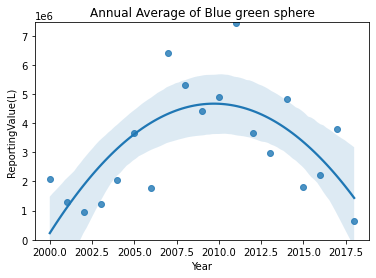

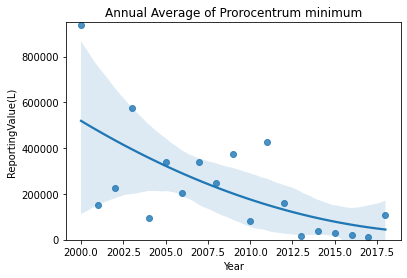

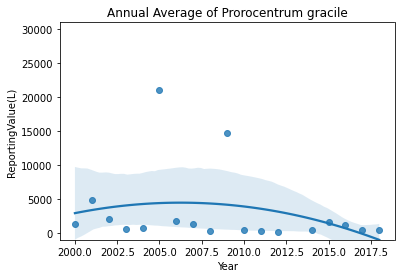

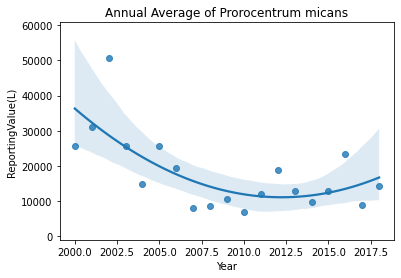

In [20]:
for name in algae_df.LatinName.unique():
    fig, ax = plt.subplots()
    temp = algae_df[algae_df['LatinName'] == name]
    temp = temp.groupby('Year').mean().reset_index()
    z = temp['ReportingValue(L)'].max() + 10000
    plt.ylim(ymin = -1000, ymax = z)
    ax = sns.regplot(data = temp, order=2, x='Year', y='ReportingValue(L)',truncate = True)
    title = "Annual Average of "+name
    ax.set_title(title)


All of the linear regressions have one common event, in between the years 2010 and 2012 there is a sharp change in the slope of the data. For the pollution data there is a rapid decline. For the microorganisms there is a rapid increase between the years 2010 and 2011 and a subsequent rapid decrease in population. In the clean up data demonstrates the most dramatic change, between 2010 and 2010 there is a median increase of HOW MANY UNITS%. The clean up activities that best displays this jump are the treatment plant retrofits and the cover crops planted. These trends suggest that there exists a relationship between pollution reduction efforts, bay pollutants, and the microorganism population.
The reason for these drastic changes in the data is most likely due to the sudden boom in microorganism population and the resulting [decision by the EPA](https://mde.maryland.gov/programs/Water/TMDL/TMDLImplementation/Pages/overview.aspx#:~:text=Reducing%20Nutrient%20Pollution%20to%20Clean,the%20Chesapeake%20Bay%20Cleanup%20Plan.) to institute a new clean up effort.

In [21]:
activites_df = pd.read_csv('Reduction_Activities.csv')
activites_df["Fiscal Year"] = list(range(2000,2015))

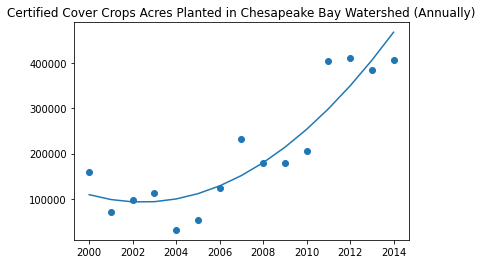

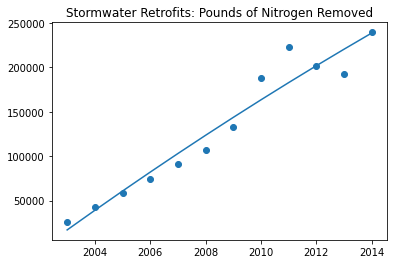

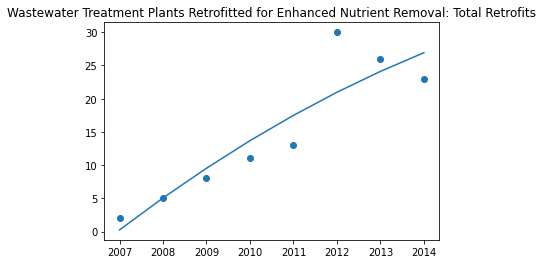

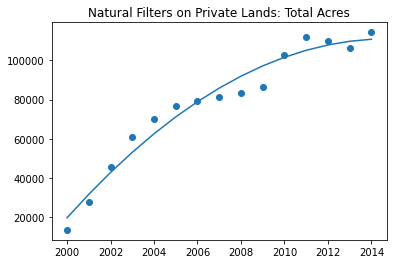

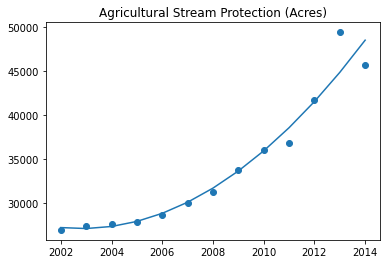

In [22]:
# from sklearn.metrics import mean_squared_error, r2_score

col_names = activites_df.columns
#each of the columns selected give the total amount of that activity for each year
temp = [1,2,5,8,11]

for i in temp:
    fig, ax = plt.subplots()
    
    activity = col_names[i] # gets the name for the selected pollution reduction activity

    #to remove NaN values in the list without removing from the dataframe
    #this is necessary because some of the activities started several years after the others
    #so there are several rows of NaN values that can not be used for some activities
    y = [i for i in activites_df[activity] if pd.notna(i)]
    x = activites_df['Fiscal Year'][-len(y):].array.reshape(-1, 1)

    polynomial_features= PolynomialFeatures(degree=2)
    x_poly = polynomial_features.fit_transform(x)

    model = LinearRegression()
    model.fit(x_poly, y)
    y_poly_pred = model.predict(x_poly)

    model = LinearRegression()
    model.fit(x_poly, y)
    y_poly_pred = model.predict(x_poly)
    plt.scatter(x, y)
    plt.plot(x, y_poly_pred)
    ax.set_title(activity)
    plt.show()

In [23]:
prorocentrum_minimum = algae_df[algae_df['LatinName'] == 'Prorocentrum minimum']
ave_N['Year'] = pd.to_numeric(ave_N['Year'])
joined = ave_N.set_index('Year').join(prorocentrum_minimum.set_index('Year'))
joined = joined.groupby('Year').mean().reset_index()
fig = plt.figure(figsize = (6, 6))
plt.scatter(joined['Total lbs.'], joined['ReportingValue(L)'])
plt.xlabel('Avg. Total lbs. of Nitrogen Pollution')
plt.ylabel('Avg. Prorocentrum Minimum Concentration in Liters')
plt.title('Total lbs of Nitrogen Pollution vs. Prorocentrum Minimum Concentration')

NameError: name 'ave_N' is not defined

As can be seen above, the algae concentration in Liters of the prorocentrum minimum species in the Chesapeake bay increases as as the average amount of nitrogen pollution increases. Although not shown here, the higher concentration values are from earlier years and the lower values are from later years. 

In [24]:
#importing, fixing, adding to, and cleaning annual rain data for maryland
average_rainfall = pd.read_csv('18-pcp-18-4-2000-2021.csv')
average_rainfall.rename(columns={" Precipitation": "Annual Precipitation (in.)"}, inplace = True)
average_rainfall = average_rainfall.drop([0,1,2], axis=0).reset_index()
average_rainfall.drop(['index',average_rainfall.columns[3]], axis=1,inplace = True)

year = []
#format for the date values is YYYYMM
for i in average_rainfall.Maryland:
    year.append(i[0:4])
    
average_rainfall["Year"] = year
average_rainfall = average_rainfall.astype(float)
average_rainfall['Scaled_Rain'] = scale_col(average_rainfall['Annual Precipitation (in.)'])

In [25]:
pm_df = algae_df[algae_df['LatinName'] == 'Prorocentrum minimum'].groupby('Year').mean().reset_index()
pm_df['Scaled_PM'] = scale_col(pm_df['ReportingValue(L)'])

In [26]:
nitrogen_2 = pd.read_csv('Updated_Nitrogen_90_19.csv')
nitrogen_2.rename(columns={'Water Year (WY)': 'Year'}, inplace = True)
nitrogen_2['Scaled_N'] = scale_col(nitrogen_2['Rounded Total (x10^6 lbs/yr)'])

phosphorus_2 = pd.read_csv('Updated_phosphorus_90_19.csv')
phosphorus_2.rename(columns={'Water Year (WY)': 'Year'}, inplace = True)
phosphorus_2['Scaled_P'] = scale_col(phosphorus_2['Rounded Total (x10^6 lbs/yr)'])

soil_df = pd.read_csv('Updated_Soil_90_19.csv')
soil_df.rename(columns={'Water Year (WY)': 'Year'}, inplace = True)
soil_df['Scaled_S'] = scale_col(soil_df['Rounded Total (x10^6 lbs/yr)'])

In [27]:
dissolved_o2 = pd.read_csv('Dissolved_oxygen.csv', low_memory =False, parse_dates=True)

wanted_number = [8,10,11,12,13,14,19,27,28]
wanted_name = []
for col in wanted_number:
    wanted_name.append(dissolved_o2.columns[col])
    
dissolved_o2.drop( unwanted_list( dissolved_o2.columns, wanted_name) ,axis = 1,inplace = True)

dissolved_o2.dropna(inplace=True)

year = []
for i in dissolved_o2.SampleDate:
    year.append(i[-4:])
dissolved_o2['Year'] = year

dissolved_o2 = dissolved_o2.rename({'MeasureValue':'MeasureValue (MG/L)'})

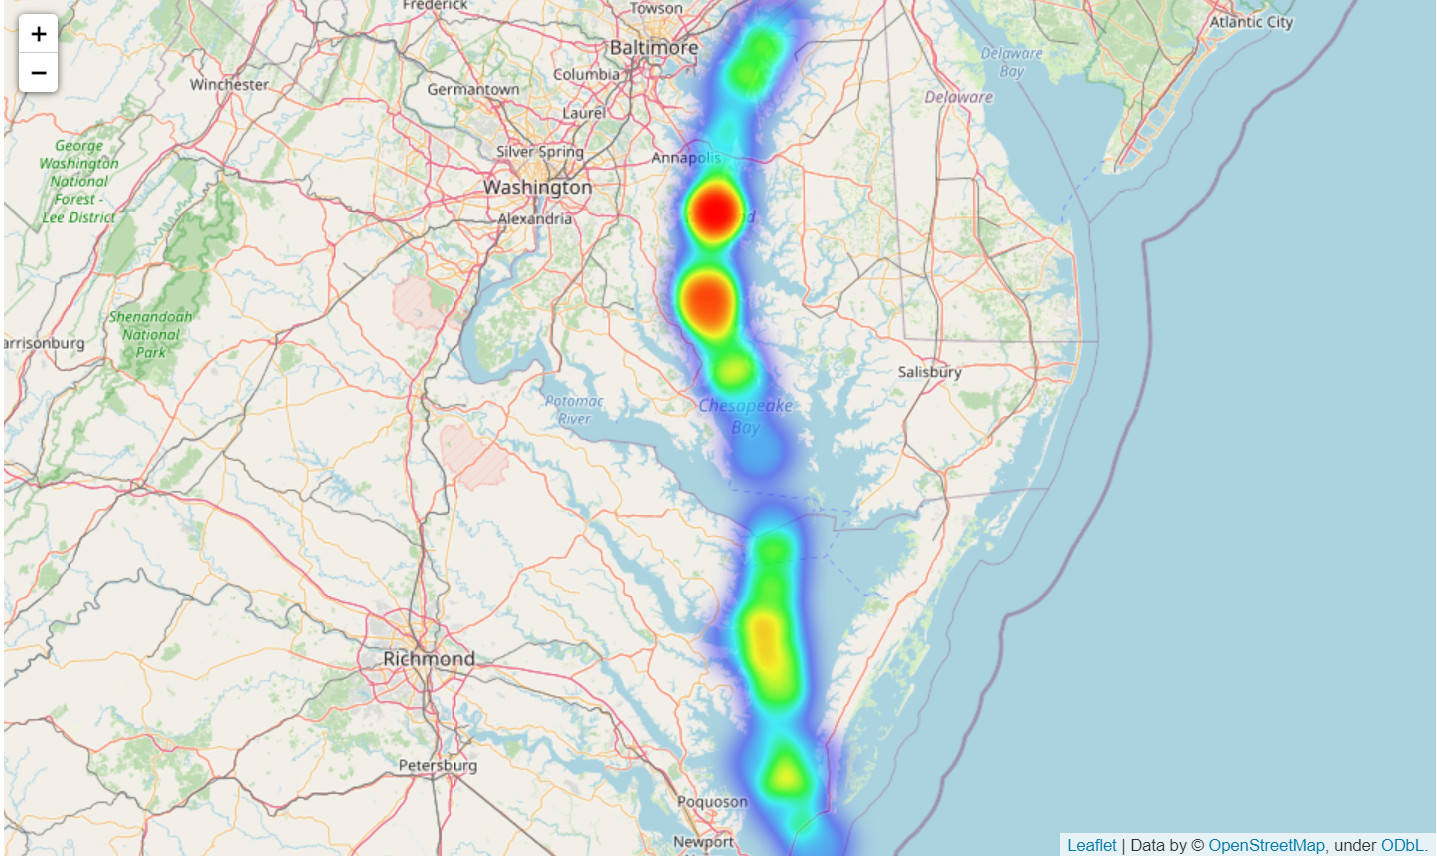

In [28]:
#Handing Heatmap general coordinates of the chesapeak bay.
heat_map = folium.Map(location=[38.2, -76.36803],
                    zoom_start = 8) 

# Need to hand it float values.
dissolved_o2['Latitude'] = dissolved_o2['Latitude'].astype(float)
dissolved_o2['Longitude'] = dissolved_o2['Longitude'].astype(float)

# Drop rows of NA.
heat_df = dissolved_o2.dropna(axis=0, subset=['Latitude','Longitude'])

# Create a data frame of just the information we want displayed.
heat_data = [[row['Latitude'],row['Longitude']] for index, row in heat_df.iterrows()]

# Plot the map using the heatmap functions.
HeatMap(heat_data).add_to(heat_map)

# Display the map.
heat_map

Image("foliumheatmap.PNG")

Initially, we tried to use Google's Google Maps API for the heatmap. After struggling with it for some time, we were able to get it to run on our local machines, however it refused to run on github. After some more research, we found that (as far as we can tell) to use Google's API properly you must submit a project and billing information to use it (in the event your project has more traffic than initally alloted.) Because of this, we went with [Folium](https://www.kaggle.com/daveianhickey/how-to-folium-for-maps-heatmaps-time-data/), which not only worked better but also is easier to use and gives a more stark realization of how real the problem is.

Text(0.5, 1.0, 'Annual Average Dissolved O2 in MG/L')

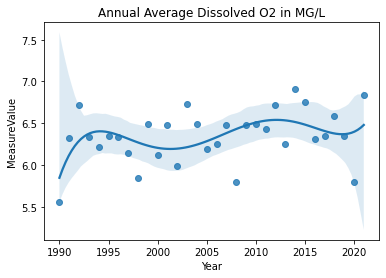

In [32]:
data =  dissolved_o2.groupby(['Year']).mean().reset_index()
data['Scaled_02'] = scale_col(data.MeasureValue)
data = data.astype(float)
X = data.Year.astype(int)
y = data["MeasureValue"]
sns.regplot(x=X, y=y, order = 5)
plt.title('Annual Average Dissolved O2 in MG/L')

Due to the limited resources of this tutorial we cannot explain every aspect of the data trends, there are hundreds of variables that can influence the amount of algae or oxygen in the bay. One example of the variables that affect the health of the bay is rainfall. I created a line plot of the averages for the average annual rainfall and nitrogen pollution.
To create the line plot I had to normalize the data so that the data worked on the same scale. I normalized the data by taking every value in the columns and subtracting the mean column value and then dividing by the column’s standard deviation. While the relationship between the two is not strong (a correlation coefficient of about 62%) it is clear that in the years that have more precipitation there is a spike in nitrogen pollution. When I researched the topic I realized that this is more than correlation, it is causation. [According to the EPA](https://www.epa.gov/soakuptherain/soak-rain-whats-problem#:~:text=Runoff%20picks%20up%20fertilizer%2C%20oil,rivers%2C%20lakes%20and%20the%20ocean.&text=Reducing%20runoff%20can%20help%20prevent,our%20precious%20drinking%20water%20resources.), the runoff water from rainfall picks up the pollutants in the ground as it finds its way into the nearest body of water. Polluted runoff means that as rainfall increases there is more runoff ending up in the Chesapeake Bay causing a spike in annual pollution. Another factor that impacts our data is geographic bias. Due to real life limitations it is impossible to get a highly accurate depiction of the bay as a whole. Not all parts of the bay are the same and some parts are cleaner than others, which can bias data averages. 

<AxesSubplot:xlabel='Year'>

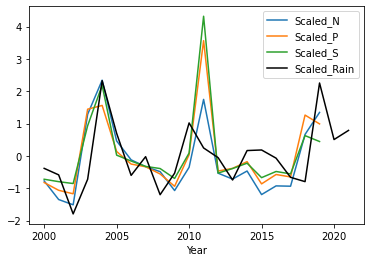

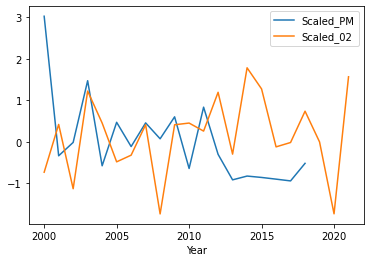

In [30]:
ax = nitrogen_2[15:].plot(x='Year', y='Scaled_N')
ax = phosphorus_2[15:].plot(ax =ax, x='Year', y='Scaled_P')
ax = soil_df[15:].plot(ax =ax, x='Year', y='Scaled_S')
average_rainfall.plot(ax =ax,x='Year', y='Scaled_Rain', color = "black")

ax = pm_df.plot(x='Year', y='Scaled_PM')
# nitrogen_2[15:].plot(ax =ax, x='Year', y='Scaled_N')
data[10:].plot(ax =ax, x='Year', y='Scaled_02')

There are dozens of variables that impact the level of pollutants and the overall health of the bay, which extrapolates a linear regression for the data most likely incorrect. An example of the limitations of my simple linear regression is that it will eventually become negative, which is impossible for pollution loads.  
The damage done by the HAB is not limited to the nutrients they consume or the toxins that they emit; they wreck the most havoc after they die. After billions of different algae die they start to decompose which is where bacteria come into the picture. Bacteria are needed to break down the billions of dead microorganisms in the water everyday. When bacteria decompose the algae, the bacteria use up oxygen in the water. Normally, bacteria breaking down dead material has no impact on the ecosystem, however, when there are billions of algae for the bacteria to decompose this destroys the oxygen in the water. This is what has happened to the Chesapeake Bay over the past few decades. As the nutrient pollution increased the amount of algae increased which led to more dead algae for bacteria to decompose. As the bacteria decompose the vast quantities they use up too much of the oxygen in the water which creates [dead zones](https://www.cbf.org/issues/dead-zones/index.html). As the bacteria take more oxygen out of the water it will be more hazardous to other aquatic life; eventually it will be deadly to them. The [EPA states](https://www.epa.gov/national-aquatic-resource-surveys/indicators-dissolved-oxygen) that the amount of dissolved oxygen in the water is a good indicator of the life that those waters can support. If you want to learn more about the lethal levels of hypoxia, the lack of oxygen in the water, look at this [four page article](https://www.esa.org/esa/wp-content/uploads/2012/12/hypoxia.pdf) by the Ecological Society of America. The improving dissolved oxygen levels demonstrate that the decades clean up have been effective. Over time the oxygen levels have improved slowly which shows promise that the bay will become more hospitable to aquatic life. 